In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = str(1)

In [2]:
appliance= 'refrigerator'
start = 6
end = 8

In [3]:
import tensorflow_probability.substrates.jax as tfp
import jax
import optax
from functools import partial
import seaborn as sns
import tensorflow as tf
dist = tfp.distributions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import scipy.stats as st
import random
from dataloader import *
from utilities import *
from model import *
from retrain_fun import *
random.seed(0)
np.random.seed(0)
jax.random.PRNGKey(0)
os.environ["XLA_FLAGS"] = "--xla_gpu_deterministic_reductions --xla_gpu_autotune_level=2"
os.environ['TF_CUDNN_DETERMINISTIC']='1'


2023-05-08 08:35:43.355266: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
data_aggregated, houses = data_preprocess()

In [5]:
train_list_furnace = [[2361, 7719, 9019, 2335, 7951]]
test_list_furnace = [[4373, 7901, 3456, 3538, 2818]]
pool_list_furnace=[]
for i in range(len(train_list_furnace)):
    pool = [j for j in houses if j not in train_list_furnace[i]+test_list_furnace[i]] #[1,2,3,3]
    pool_list_furnace.append(pool) #pool list = [[1,2,3,3]]

train_list_clotheswasher = [[2361, 7719, 9019, 2335, 7951]]
test_list_clotheswasher = [[4373, 7901, 3456, 3538, 2818]]
pool_list_clotheswasher=[]
for i in range(len(train_list_clotheswasher)):
    pool = [j for j in houses if j not in train_list_clotheswasher[i]+test_list_clotheswasher[i]]
    pool_list_clotheswasher.append(pool)

train_list_dishwasher = [[2361, 7719, 9019, 2335, 7951]]
test_list_dishwasher = [[4373, 7901, 3456, 3538, 2818]]
pool_list_dishwasher=[]
for i in range(len(train_list_dishwasher)):
    pool = [j for j in houses if j not in train_list_dishwasher[i]+test_list_dishwasher[i]]
    pool_list_dishwasher.append(pool)

train_list_refrigerator =  [[2361, 7719, 9019, 2335, 7951]]
test_list_refrigerator = [[4373, 7901, 3456, 3538, 2818]]
pool_list_refrigerator=[]
for i in range(len(train_list_refrigerator)):
    pool = [j for j in houses if j not in train_list_refrigerator[i]+test_list_refrigerator[i]]
    pool_list_refrigerator.append(pool)


train_list_air = [[2361, 7719, 9019, 2335, 7951]]
test_list_air = [[4373, 7901, 3456, 3538, 2818]]
pool_list_air=[]
for i in range(len(train_list_air)):
    pool = [j for j in houses if j not in train_list_air[i]+test_list_air[i]]
    pool_list_air.append(pool)


In [6]:
all_appliance_train_lists = {
    'air':train_list_air, 'furnace':train_list_furnace,'dishwasher':train_list_dishwasher, 'refrigerator':train_list_refrigerator, 'clotheswasher':train_list_clotheswasher
}
all_appliance_test_lists = {
    'air':test_list_air, 'furnace':test_list_furnace,'dishwasher':test_list_dishwasher, 'refrigerator':test_list_refrigerator, 'clotheswasher':test_list_clotheswasher
}
all_appliance_pool_lists = {
    'air':pool_list_air, 'furnace':pool_list_furnace,'dishwasher':pool_list_dishwasher, 'refrigerator':pool_list_refrigerator, 'clotheswasher':pool_list_clotheswasher
}

In [7]:
random_picks = {'furnace':[[8156, 661, 7800, 8386, 8565, 5746, 9278, 7536, 1642, 9160],
 [7800, 9160, 8565, 661, 1642, 9278, 8156, 7536, 5746, 8386],
 [8565, 9160, 8386, 661, 5746, 7536, 7800, 1642, 9278, 8156],
 [7800, 7536, 661, 8386, 9278, 1642, 8565, 5746, 9160, 8156],
 [7536, 7800, 8156, 9278, 661, 5746, 8386, 8565, 9160, 1642],
 [661, 8156, 9278, 7800, 8386, 7536, 9160, 1642, 5746, 8565],
 [661, 1642, 8386, 9160, 9278, 5746, 7536, 8156, 8565, 7800],
 [7800, 9278, 1642, 5746, 7536, 8156, 9160, 8565, 8386, 661],
 [5746, 661, 9160, 8156, 9278, 8565, 7536, 8386, 1642, 7800],
 [7800, 8565, 8156, 8386, 7536, 9278, 661, 1642, 5746, 9160]],
 'clotheswasher_og':[[8156, 661, 7800, 8386, 8565, 5746, 9278, 7536, 1642, 9160],
 [7800, 9160, 8565, 661, 1642, 9278, 8156, 7536, 5746, 8386],
 [8565, 9160, 8386, 661, 5746, 7536, 7800, 1642, 9278, 8156],
 [7800, 7536, 661, 8386, 9278, 1642, 8565, 5746, 9160, 8156],
 [7536, 7800, 8156, 9278, 661, 5746, 8386, 8565, 9160, 1642],
 [661, 8156, 9278, 7800, 8386, 7536, 9160, 1642, 5746, 8565],
 [661, 1642, 8386, 9160, 9278, 5746, 7536, 8156, 8565, 7800],
 [7800, 9278, 1642, 5746, 7536, 8156, 9160, 8565, 8386, 661],
 [5746, 661, 9160, 8156, 9278, 8565, 7536, 8386, 1642, 7800],
 [7800, 8565, 8156, 8386, 7536, 9278, 661, 1642, 5746, 9160]],
 'clotheswasher':[[8156, 661, 7800, 8386, 8565, 5746, 9278, 7536, 1642, 9160],
 [7800, 9160, 8565, 661, 1642, 9278, 8156, 7536, 5746, 8386],
 [8565, 9160, 8386, 661, 5746, 7536, 7800, 1642, 9278, 8156],
 [7800, 7536, 661, 8386, 9278, 1642, 8565, 5746, 9160, 8156],
 [7536, 7800, 8156, 9278, 661, 5746, 8386, 8565, 9160, 1642],
 [661, 8156, 9278, 7800, 8386, 7536, 9160, 1642, 5746, 8565],
 [661, 1642, 8386, 9160, 9278, 5746, 7536, 8156, 8565, 7800],
 [7800, 9278, 1642, 5746, 7536, 8156, 9160, 8565, 8386, 661],
 [5746, 661, 9160, 8156, 9278, 8565, 7536, 8386, 1642, 7800],
 [7800, 8565, 8156, 8386, 7536, 9278, 661, 1642, 5746, 9160]]
 , 
 'refrigerator':[[8156, 661, 7800, 8386, 8565, 5746, 9278, 7536, 1642, 9160],
 [7800, 9160, 8565, 661, 1642, 9278, 8156, 7536, 5746, 8386],
 [8565, 9160, 8386, 661, 5746, 7536, 7800, 1642, 9278, 8156],
 [7800, 7536, 661, 8386, 9278, 1642, 8565, 5746, 9160, 8156],
 [7536, 7800, 8156, 9278, 661, 5746, 8386, 8565, 9160, 1642],
 [661, 8156, 9278, 7800, 8386, 7536, 9160, 1642, 5746, 8565],
 [661, 1642, 8386, 9160, 9278, 5746, 7536, 8156, 8565, 7800],
 [7800, 9278, 1642, 5746, 7536, 8156, 9160, 8565, 8386, 661],
 [5746, 661, 9160, 8156, 9278, 8565, 7536, 8386, 1642, 7800],
 [7800, 8565, 8156, 8386, 7536, 9278, 661, 1642, 5746, 9160]], 
 'dishwasher':[[8156, 661, 7800, 8386, 8565, 5746, 9278, 7536, 1642, 9160],
 [7800, 9160, 8565, 661, 1642, 9278, 8156, 7536, 5746, 8386],
 [8565, 9160, 8386, 661, 5746, 7536, 7800, 1642, 9278, 8156],
 [7800, 7536, 661, 8386, 9278, 1642, 8565, 5746, 9160, 8156],
 [7536, 7800, 8156, 9278, 661, 5746, 8386, 8565, 9160, 1642],
 [661, 8156, 9278, 7800, 8386, 7536, 9160, 1642, 5746, 8565],
 [661, 1642, 8386, 9160, 9278, 5746, 7536, 8156, 8565, 7800],
 [7800, 9278, 1642, 5746, 7536, 8156, 9160, 8565, 8386, 661],
 [5746, 661, 9160, 8156, 9278, 8565, 7536, 8386, 1642, 7800],
 [7800, 8565, 8156, 8386, 7536, 9278, 661, 1642, 5746, 9160]], 
 'air': [[8156, 661, 7800, 8386, 8565, 5746, 9278, 7536, 1642, 9160],
 [7800, 9160, 8565, 661, 1642, 9278, 8156, 7536, 5746, 8386],
 [8565, 9160, 8386, 661, 5746, 7536, 7800, 1642, 9278, 8156],
 [7800, 7536, 661, 8386, 9278, 1642, 8565, 5746, 9160, 8156],
 [7536, 7800, 8156, 9278, 661, 5746, 8386, 8565, 9160, 1642],
 [661, 8156, 9278, 7800, 8386, 7536, 9160, 1642, 5746, 8565],
 [661, 1642, 8386, 9160, 9278, 5746, 7536, 8156, 8565, 7800],
 [7800, 9278, 1642, 5746, 7536, 8156, 9160, 8565, 8386, 661],
 [5746, 661, 9160, 8156, 9278, 8565, 7536, 8386, 1642, 7800],
 [7800, 8565, 8156, 8386, 7536, 9278, 661, 1642, 5746, 9160]]
}

STARTING FOR refrigerator, FOR ITERATIONS - 6 to 8
############################################Random iteration number#################################### : 7
I am pool houses picck [5746, 8565, 9278, 8156, 8386, 9160, 661, 1642, 7536, 7800]
-------------------------------------------Iteration No:----------------------------------------- -> 6.0
RMSE : 74.6309 MAE  : 44.3787 NLL : 6.1706
I am random house id = 661
I am pool houses [5746, 8565, 9278, 8156, 8386, 9160, 661, 1642, 7536, 7800]
(array([6]),)
[6]
6
-------------------------------------------Iteration No:----------------------------------------- -> 6.1


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951  661]
(113214, 99)


2023-05-08 08:36:50.461442: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[113214,50,99]{2,1,0}, u8[0]{0}) custom-call(f32[113214,50,99]{2,1,0}, f32[50,50,5]{2,1,0}), window={size=5 pad=2_2}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 84.7843 MAE  : 63.3008 NLL : 5.8793
-------------------------------------------Iteration No:----------------------------------------- -> 6.2


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951  661 1642]
(163613, 99)


2023-05-08 08:37:09.661940: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[163613,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[163613,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-05-08 08:37:10.780703: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[163613,50,99]{2,1,0}, u8[0]{0}) custom-call(f32[163613,40,99]{2,1,0}, f32[50,40,5]{2,1,0}), window={size=5 pad=2_2}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-05

RMSE : 77.7101 MAE  : 51.8836 NLL : 6.0344
-------------------------------------------Iteration No:----------------------------------------- -> 6.3


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951  661 1642 8386]
(221212, 99)


2023-05-08 08:37:34.617390: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[221212,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[221212,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-05-08 08:37:35.784241: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[221212,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[221212,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-05-08 08:

RMSE : 92.0765 MAE  : 64.4093 NLL : 6.0167
-------------------------------------------Iteration No:----------------------------------------- -> 6.4


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951  661 1642 8386 9160]
(298971, 99)


2023-05-08 08:38:07.596684: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[298971,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[298971,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-05-08 08:38:09.126545: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[298971,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[298971,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-05-08 08:

RMSE : nan MAE  : nan NLL : nan
-------------------------------------------Iteration No:----------------------------------------- -> 6.5


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951  661 1642 8386 9160 9278]
(370970, 99)


2023-05-08 08:38:49.387579: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[370970,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[370970,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-05-08 08:38:51.263711: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[370970,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[370970,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-05-08 08:

RMSE : 83.6715 MAE  : 61.7379 NLL : 5.8491
-------------------------------------------Iteration No:----------------------------------------- -> 6.6


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951  661 1642 8386 9160 9278 5746]
(447709, 99)


2023-05-08 08:39:39.645858: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[447709,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[447709,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-05-08 08:39:41.878227: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[447709,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[447709,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 83.7187 MAE  : 62.5734 NLL : 5.8500
-------------------------------------------Iteration No:----------------------------------------- -> 6.7


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951  661 1642 8386 9160 9278 5746 7536]
(534093, 99)


2023-05-08 08:40:39.221015: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[534093,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[534093,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-05-08 08:40:41.855053: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[534093,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[534093,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 83.6703 MAE  : 61.8195 NLL : 5.8513
-------------------------------------------Iteration No:----------------------------------------- -> 6.8


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951  661 1642 8386 9160 9278 5746 7536 8156]
(627692, 99)


2023-05-08 08:41:49.313831: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[627692,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[627692,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-05-08 08:41:52.385351: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[627692,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[627692,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : nan MAE  : nan NLL : nan
-------------------------------------------Iteration No:----------------------------------------- -> 6.9


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951  661 1642 8386 9160 9278 5746 7536 8156 8565]
(728491, 99)


2023-05-08 08:43:13.707928: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[728491,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[728491,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 83.6704 MAE  : 61.8090 NLL : 5.8513
############################################Random iteration number#################################### : 8
I am pool houses picck [5746, 8565, 9278, 8156, 8386, 9160, 661, 1642, 7536, 7800]
-------------------------------------------Iteration No:----------------------------------------- -> 7.0
RMSE : 74.6309 MAE  : 44.3787 NLL : 6.1706
I am random house id = 7800
I am pool houses [5746, 8565, 9278, 8156, 8386, 9160, 661, 1642, 7536, 7800]
(array([9]),)
[9]
9
-------------------------------------------Iteration No:----------------------------------------- -> 7.1


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 7800]
(113214, 99)
RMSE : 67.3943 MAE  : 35.0053 NLL : 5.1451
-------------------------------------------Iteration No:----------------------------------------- -> 7.2


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 7800 9278]
(163613, 99)
RMSE : 71.2296 MAE  : 39.5769 NLL : 5.5170
-------------------------------------------Iteration No:----------------------------------------- -> 7.3


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 7800 9278 1642]
(221212, 99)
RMSE : 66.6836 MAE  : 33.0349 NLL : 7.9521
-------------------------------------------Iteration No:----------------------------------------- -> 7.4


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 7800 9278 1642 5746]
(296691, 99)


2023-05-08 08:45:49.503828: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[296691,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[296691,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-05-08 08:45:51.033659: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[296691,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[296691,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-05-08 08:

RMSE : 72.1948 MAE  : 44.6355 NLL : 6.5322
-------------------------------------------Iteration No:----------------------------------------- -> 7.5


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 7800 9278 1642 5746 7536]
(368690, 99)


2023-05-08 08:46:30.967574: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[368690,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[368690,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-05-08 08:46:32.844227: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[368690,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[368690,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-05-08 08:

RMSE : 415.0802 MAE  : 408.0327 NLL : 8.2613
-------------------------------------------Iteration No:----------------------------------------- -> 7.6


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 7800 9278 1642 5746 7536 8156]
(446269, 99)


2023-05-08 08:47:21.085116: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[446269,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[446269,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-05-08 08:47:23.303337: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[446269,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[446269,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : nan MAE  : nan NLL : nan
-------------------------------------------Iteration No:----------------------------------------- -> 7.7


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 7800 9278 1642 5746 7536 8156 9160]
(532653, 99)


2023-05-08 08:48:19.736792: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[532653,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[532653,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-05-08 08:48:22.363824: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[532653,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[532653,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 65.3426 MAE  : 32.7529 NLL : 5.4334
-------------------------------------------Iteration No:----------------------------------------- -> 7.8


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 7800 9278 1642 5746 7536 8156 9160 8565]
(626252, 99)


2023-05-08 08:49:29.681369: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[626252,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[626252,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-05-08 08:49:32.743569: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[626252,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[626252,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : nan MAE  : nan NLL : nan
-------------------------------------------Iteration No:----------------------------------------- -> 7.9


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 7800 9278 1642 5746 7536 8156 9160 8565 8386]
(727051, 99)


2023-05-08 08:50:53.607558: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[727051,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[727051,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 81.1468 MAE  : 60.9222 NLL : 5.8645


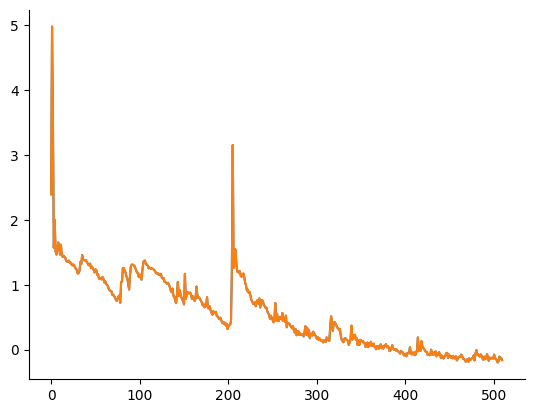

In [8]:
total_rmse=[]
houseids=[]

all_rmses = dict()
all_maes = dict() 
all_preds = dict() 

iteration_number = f'{start}_{end}_iterations'

print(f"STARTING FOR {appliance}, FOR ITERATIONS - {start} to {end}")

for i in range(start,end): #total 10 iterations

    print(f"############################################Random iteration number#################################### : {i+1}")

    train_houses = all_appliance_train_lists[appliance][0] 
    test_houses = all_appliance_test_lists[appliance][0] 
    pool_houses = all_appliance_pool_lists[appliance][0] 

    print(f"I am pool houses picck {pool_houses}")
    
    
    train = data_aggregated[data_aggregated["dataid"].isin(train_houses)] 
    test = data_aggregated[data_aggregated["dataid"].isin(test_houses)]

    all_rmses[i] = []
    all_maes[i] = []
    all_preds[i] = []
    
    houses=[]

    start= ["2018-03-01 00:00:00-06","2018-03-11 00:00:00-06","2018-03-16 00:00:00-06","2018-03-21 00:00:00-06","2018-03-26 00:00:00-06","2018-04-01 00:00:00-06", "2018-04-06 00:00:00-06", "2018-04-11 00:00:00-06", "2018-04-16 00:00:00-06", "2018-04-21 00:00:00-06"]
    end=   ["2018-03-10 23:59:00-06","2018-03-15 23:59:00-06","2018-03-20 23:59:00-06","2018-03-25 23:59:00-06","2018-03-31 23:59:00-06","2018-04-05 23:59:00-06", "2018-04-10 23:59:00-06", "2018-04-15 23:59:00-06", "2018-04-20 23:59:00-06", "2018-04-25 23:59:00-06"]
    
    for j in range(len(start)):
        
        
        print(f"-------------------------------------------Iteration No:----------------------------------------- -> {i}.{j}")

        if(j==0):
            rmsee, maes, train, test,current_pred = retrain_random(0, start[j], end[j], pool_houses, train, test,appliance, data_aggregated)
            all_rmses[i].append(rmsee.item())
            all_maes[i].append(maes.item())
            all_preds[i].append(current_pred)

            random_house_id = random_picks[appliance][i][j]
            print(f"I am random house id = {random_house_id}")
            print(f"I am pool houses {pool_houses}")
            print(f"{np.where(np.array(pool_houses)==random_house_id)}")
            print(f"{np.where(np.array(pool_houses)==random_house_id)[0]}")
            print(f"{np.where(np.array(pool_houses)==random_house_id)[0][0]}")
            random_house_index = np.where(np.array(pool_houses)==random_house_id)[0][0]  

            houses.append(random_house_id)
            pool_houses= np.delete(pool_houses, random_house_index)
            # break #REMOVE AT THE END

        elif(j==10):
            rmsee, maes, train, test,current_pred = retrain_random(random_house_id, start[j], end[j], pool_houses, train, test,appliance, data_aggregated)
            all_rmses[i].append(rmsee.item())
            all_maes[i].append(maes.item())
            all_preds[i].append(current_pred)

        else:
            rmsee, maes, train, test,current_pred = retrain_random(random_house_id, start[j], end[j], pool_houses, train, test,appliance, data_aggregated)
            all_rmses[i].append(rmsee.item())
            all_maes[i].append(maes.item())
            all_preds[i].append(current_pred)

            random_house_id = random_picks[appliance][i][j]
            
            random_house_index = np.where(np.array(pool_houses)==random_house_id)[0][0]  
            
            houses.append(random_house_id)
            pool_houses= np.delete(pool_houses, random_house_index)
        
        
    # total_rmse.append(rmse_iter)
    houseids.append(houses)
    
    # if i not in all_rmses:
    #     all_rmses[i] = total_rmse




In [11]:
name_of_file_rmses = "random"+"_"+str(iteration_number) + "RMSES"+".csv"
name_of_file_maes = "random"+"_"+str(iteration_number) + "MAES"+".csv"
# name_of_file_preds = str(random)+"_"+str(iteration_number)+"PREDS"+".csv"

if not os.path.exists(f'{appliance}'):
    os.mkdir(f'{appliance}')

# Save the DataFrame to a CSV file
pd.DataFrame(all_rmses).to_csv(os.path.join(f'{appliance}', f'{name_of_file_rmses}'), index=False)
pd.DataFrame(all_maes).to_csv(os.path.join(f'{appliance}', f'{name_of_file_maes}'), index=False)
# pd.DataFrame(all_preds).to_csv(os.path.join(f'{appliance}', f'{name_of_file_preds}'), index=False)